**Import the Libraries**

In [1]:
import csv
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
print(tf.__version__)

2022-11-17 18:23:10.011441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 18:23:17.855474: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 18:23:17.855539: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-17 18:23:18.345622: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-17 18:23:31.722078: W tensorflow/stream_executor/platform/de

2.10.0


In [2]:
!pip install nltk

**Get the Data**

In [3]:
df = pd.read_csv("bbc-text.csv")

In [4]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [5]:
df['text'][71]

'singapore growth at 8.1% in 2004 singapore s economy grew by 8.1% in 2004  its best performance since 2000  figures from the trade ministry show.  the advance  the second-fastest in asia after china  was led by growth of 13.1% in the key manufacturing sector. however  a slower-than-expected fourth quarter points to more modest growth for the trade-driven economy in 2005 as global technology demand falls back. slowdowns in the us and china could hit electronics exports  while the tsunami disaster may effect the service sector.  economic growth is set to halve in singapore this year to between 3% and 5%. in the fourth quarter  the city state s gross domestic product (gdp) rose at an annual rate of 2.4%. that was up from the third quarter  when it fell 3.0%  but was well below analyst forecasts.  i am surprised at the weak fourth quarter number. the main drag came from electronics   said lian chia liang  economist at jp morgan chase. singapore s economy had contracted over the summer  we

**Import NTLK Library**

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/mukesh/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Set the Hyper-Parameters**

In [7]:
vocab_size = 5000 
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' #OOV = Out of Vocabulary
training_portion = .8

**Populate List and Remove the Stopwords**

In [8]:
articles = []
labels = []

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


In [9]:
labels[:2]

['tech', 'business']

In [10]:
articles[:2]

['tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes. us leading trend  programmes content delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us tivo uk sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take europe lack high-definition programming. people forward wind adverts  also forget abiding network channel schedules  putting together a-la-carte entertainment. us networks cable satellite companie

**Create Training and Validation Set**

In [11]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print("train_size",  train_size)
print(f"train_articles {len(train_articles)}")
print("train_labels", len(train_labels))
print("validation_articles", len(validation_articles))
print("validation_labels", len(validation_labels))

train_size 1780
train_articles 1780
train_labels 1780
validation_articles 445
validation_labels 445


**Tokenization on "train_articles"**

In [12]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

**Convert to Sequences on "train_articles"**

In [13]:
train_sequences = tokenizer.texts_to_sequences(train_articles)

In [14]:
print(train_sequences[10]), len(train_sequences[10])

[2431, 1, 225, 4994, 22, 641, 587, 225, 4994, 1, 1, 1662, 1, 1, 2431, 22, 565, 1, 1, 140, 278, 1, 140, 278, 796, 822, 662, 2307, 1, 1144, 1693, 1, 1720, 4995, 1, 1, 1, 1, 1, 4737, 1, 1, 122, 4513, 1, 2, 2874, 1504, 352, 4738, 1, 52, 341, 1, 352, 2171, 3962, 41, 22, 3794, 1, 1, 1, 1, 543, 1, 1, 1, 835, 631, 2366, 347, 4739, 1, 365, 22, 1, 787, 2367, 1, 4301, 138, 10, 1, 3665, 682, 3532, 1, 22, 1, 414, 822, 662, 1, 90, 13, 633, 1, 225, 4994, 1, 600, 1, 1693, 1021, 1, 4996, 807, 1863, 117, 1, 1, 1, 2974, 22, 1, 99, 278, 1, 1606, 4997, 543, 492, 1, 1444, 4740, 778, 1320, 1, 1860, 10, 33, 641, 319, 1, 62, 478, 565, 301, 1505, 22, 479, 1, 1, 1665, 1, 797, 1, 3066, 1, 1364, 6, 1, 2431, 565, 22, 2971, 4734, 1, 1, 1, 1, 1, 850, 39, 1824, 675, 297, 26, 979, 1, 882, 22, 361, 22, 13, 301, 1505, 1342, 374, 20, 63, 883, 1096, 4302, 247]


(None, 186)

In [15]:
print(train_sequences[0]), len(train_sequences[0])

[91, 160, 1141, 1106, 49, 979, 755, 1, 89, 1304, 4288, 129, 175, 3654, 1213, 1194, 1576, 42, 7, 893, 91, 1, 334, 85, 20, 14, 130, 3262, 1214, 2421, 570, 451, 1375, 58, 3378, 3522, 1660, 8, 921, 730, 10, 844, 1, 9, 599, 1577, 1107, 395, 1940, 1106, 731, 49, 538, 1397, 2012, 1622, 134, 249, 113, 2355, 795, 4979, 980, 584, 10, 3956, 3957, 921, 2562, 129, 344, 175, 3654, 1, 1, 39, 62, 2867, 28, 9, 4722, 18, 1305, 136, 416, 7, 143, 1422, 71, 4500, 436, 4980, 91, 1107, 77, 1, 82, 2013, 53, 1, 91, 6, 1008, 591, 89, 1304, 91, 1964, 131, 137, 420, 9, 2868, 38, 152, 1233, 89, 1304, 4723, 7, 436, 4980, 3153, 6, 2492, 1, 431, 1126, 1, 1423, 571, 1234, 1902, 1, 766, 9, 538, 1397, 2012, 134, 2069, 400, 845, 1965, 1599, 34, 1716, 2869, 1, 1, 2422, 244, 9, 2624, 82, 732, 6, 1172, 1195, 152, 720, 592, 1, 124, 28, 1305, 1689, 432, 83, 933, 115, 20, 14, 18, 3154, 1, 37, 1483, 1, 23, 37, 87, 335, 2356, 37, 467, 255, 1965, 1358, 328, 1, 299, 732, 1173, 18, 2870, 1716, 1, 294, 756, 1074, 395, 2014, 387, 431

(None, 426)

**Padding and Truncating on "train_sequences"**

In [16]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [17]:
train_padded[10]

array([2431,    1,  225, 4994,   22,  641,  587,  225, 4994,    1,    1,
       1662,    1,    1, 2431,   22,  565,    1,    1,  140,  278,    1,
        140,  278,  796,  822,  662, 2307,    1, 1144, 1693,    1, 1720,
       4995,    1,    1,    1,    1,    1, 4737,    1,    1,  122, 4513,
          1,    2, 2874, 1504,  352, 4738,    1,   52,  341,    1,  352,
       2171, 3962,   41,   22, 3794,    1,    1,    1,    1,  543,    1,
          1,    1,  835,  631, 2366,  347, 4739,    1,  365,   22,    1,
        787, 2367,    1, 4301,  138,   10,    1, 3665,  682, 3532,    1,
         22,    1,  414,  822,  662,    1,   90,   13,  633,    1,  225,
       4994,    1,  600,    1, 1693, 1021,    1, 4996,  807, 1863,  117,
          1,    1,    1, 2974,   22,    1,   99,  278,    1, 1606, 4997,
        543,  492,    1, 1444, 4740,  778, 1320,    1, 1860,   10,   33,
        641,  319,    1,   62,  478,  565,  301, 1505,   22,  479,    1,
          1, 1665,    1,  797,    1, 3066,    1, 13

In [18]:
print("len train_sequnces[0]: ", len(train_sequences[0]))
print("len train_padded[0]: ", len(train_padded[0]))

print("len train_sequences[1]: ", len(train_sequences[1]))
print("len train_padded[1]: ", len(train_padded[1]))

print("len train_sequences[10]: ", len(train_sequences[10]))
print("len train_padded[10]: ", len(train_padded[10]))

len train_sequnces[0]:  426
len train_padded[0]:  200
len train_sequences[1]:  192
len train_padded[1]:  200
len train_sequences[10]:  186
len train_padded[10]:  200


**Convert to Sequence, Padding & Truncating on "validation_articles"**

In [19]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 200)


**Labels**

In [20]:
print(set(labels))

{'business', 'sport', 'tech', 'entertainment', 'politics'}


**Tokenize and Convert to Sequence on "train_labels" and "validation_labels"**

In [21]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [22]:
#labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
label_tokenizer.word_index

{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}

In [23]:
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)
print('-------------')
print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
-------------
[5]
[4]
[3]
(445, 1)


**Create Model**

In [24]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(LSTM(embedding_dim))
model.add(Dense(6, activation='softmax'))

model.summary()

2022-11-17 18:29:41.443027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-17 18:29:41.455443: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-17 18:29:41.455565: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mukesh-Inspiron-5468): /proc/driver/nvidia/version does not exist
2022-11-17 18:29:41.497814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 353,414
Trainable params: 353,414
Non-trainable params: 0
_________________________________________________________________


**Compile the Model**

In [25]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

/home/mukesh/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


**Train the Model**

In [26]:
num_epochs = 20
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/20
56/56 - 11s - loss: 1.6469 - accuracy: 0.2607 - val_loss: 1.5177 - val_accuracy: 0.3483 - 11s/epoch - 196ms/step
Epoch 2/20
56/56 - 6s - loss: 1.5009 - accuracy: 0.3579 - val_loss: 1.4817 - val_accuracy: 0.3978 - 6s/epoch - 107ms/step
Epoch 3/20
56/56 - 5s - loss: 1.3262 - accuracy: 0.4545 - val_loss: 1.2772 - val_accuracy: 0.4202 - 5s/epoch - 84ms/step
Epoch 4/20
56/56 - 5s - loss: 1.5791 - accuracy: 0.3421 - val_loss: 1.4835 - val_accuracy: 0.3416 - 5s/epoch - 84ms/step
Epoch 5/20
56/56 - 6s - loss: 1.3724 - accuracy: 0.4219 - val_loss: 1.2997 - val_accuracy: 0.4472 - 6s/epoch - 100ms/step
Epoch 6/20
56/56 - 5s - loss: 1.2464 - accuracy: 0.4848 - val_loss: 1.5025 - val_accuracy: 0.4337 - 5s/epoch - 90ms/step
Epoch 7/20
56/56 - 6s - loss: 1.2860 - accuracy: 0.4382 - val_loss: 1.2905 - val_accuracy: 0.4629 - 6s/epoch - 103ms/step
Epoch 8/20
56/56 - 6s - loss: 1.0945 - accuracy: 0.5697 - val_loss: 1.0793 - val_accuracy: 0.5685 - 6s/epoch - 99ms/step
Epoch 9/20
56/56 - 5s - lo

**Plot the Graph**

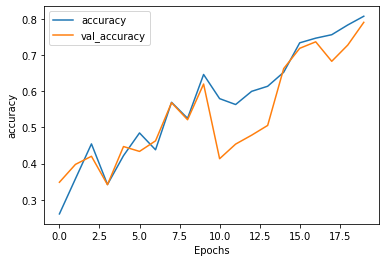

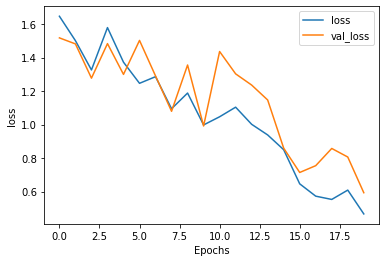

In [27]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**Prediction**

In [28]:
txt = ["singapore growth at 8.1% in 2004 singapore s economy grew by 8.1% in 2004  its best performance since 2000  figures from the trade ministry show.  the advance  the second-fastest in asia after china  was led by growth of 13.1% in the key manufacturing sector. however  a slower-than-expected fourth quarter points to more modest growth for the trade-driven economy in 2005 as global technology demand falls back. slowdowns in the us and china could hit electronics exports  while the tsunami disaster may effect the service sector.  economic growth is set to halve in singapore this year to between 3% and 5%. in the fourth quarter  the city state s gross domestic product (gdp) rose at an annual rate of 2.4%. that was up from the third quarter  when it fell 3.0%  but was well below analyst forecasts.  i am surprised at the weak fourth quarter number. the main drag came from electronics  "]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment'] #orig

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)-1])

1/1 [==============================] - 0s 468ms/step
[[0.00528715 0.01796208 0.8004342  0.11477432 0.02670716 0.03483511]]
2
bussiness
